# MobileNetV2

- Implementation, comparisong and benchmarking of: Convolutions, Blocks, Model
- Implementation: Simple, clean OOP implementations with minimal parametrisations
- Comparisons: Parameters, runtime, accuracy
- Benchmarking: Comparison to VGG and ResNets on CIFAR100

1. Convolutions
- Normal, Depthwise
- Comparison: Parameter and Activation Shapes

2. Blocks
- Standard (VGG), Depthwise Separable (MobileNetV1), Residual Bottleneck (ResNets), Interted Residual Bottleneck (MobileNetV2)
- Comparison: Blocks as simple classifiers on MNIST, instantiated to have similar number of params for fair comparison

3. Model
- MobileNetV2 Implementation
- Benchmarking against VGG16, ResNet50 by also using multiple width multipliers to have similar number of params as the baselines
- Comparison: Params, MACs, runtime, Accuracy on CIFAR100

In [1]:
import torch
from torch import nn
from torchvision import transforms 
from torchvision.datasets import MNIST, CIFAR100
from torch.utils.data import DataLoader

import joblib
from datetime import datetime
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict

%config Completer.use_jedi = False

In [ ]:
def named_shape(names, tensor):
    return {k: v for k, v in zip(names, tensor.shape)} 

# 1. Convolutions
- Comparision of the weights and activations of the two convolution options

In [ ]:
N = 2      # Nr or data points (input images)
C = 4      # Nr Channels of input image
H = 10     # Height of the input image
W = 10     # Width of the input image
F = 5      # Nr of Filters in Conv (Out size, out channels)
K = (3, 3) # Kernel Size

X = torch.randn(N, C, H, W)

## 1.1 Normal Conv
- A filter of shape [C, K, K] convolves the information of all input channels

In [29]:
std_conv = nn.Conv2d(in_channels=C, out_channels=F, kernel_size=K)

print("Input shape:", named_shape(["N", "C", "H", "W"], X))
print("Kernel shape:", named_shape(["F", "C", "K_h", "K_w"], std_conv.weight))
print("Output shape:", named_shape(["N", "C*", "H*", "W*"], std_conv(X)))

Input shape: {'N': 2, 'C': 4, 'H': 10, 'W': 10}
Kernel shape: {'F': 5, 'C': 4, 'K_h': 3, 'K_w': 3}
Output shape: {'N': 2, 'C*': 5, 'H*': 8, 'W*': 8}


## 1.2 Depthwise Conv
- A filter of shape [1, K, K] convlves the information of a single input channel
- Note that because each input channel has it's own filter, the layer cannot change the number of channels of it's input. That's where the 1x1 layer comes in.

In [33]:
depth_conv = nn.Conv2d(in_channels=C, out_channels=C, kernel_size=K, groups=C)

print("Input shape:", named_shape(["N", "C", "H", "W"], X))
print("Kernel shape:", named_shape(["F", "C", "K_h", "K_w"], depth_conv.weight))
print("Output shape:", named_shape(["N", "C*", "H*", "W*"], depth_conv(X)))

Input shape: {'N': 2, 'C': 4, 'H': 10, 'W': 10}
Kernel shape: {'F': 4, 'C': 1, 'K_h': 3, 'K_w': 3}
Output shape: {'N': 2, 'C*': 4, 'H*': 8, 'W*': 8}


In [34]:
point_conv = nn.Conv2d(in_channels=C, out_channels=F, kernel_size=1)

print("Input shape:", named_shape(["N", "C", "H", "W"], depth_conv(X)))
print("Kernel shape:", named_shape(["F", "C", "K_h", "K_w"], point_conv.weight))
print("Output shape:", named_shape(["N", "C*", "H*", "W*"], point_conv(depth_conv(X))))

Input shape: {'N': 2, 'C': 4, 'H': 8, 'W': 8}
Kernel shape: {'F': 5, 'C': 4, 'K_h': 1, 'K_w': 1}
Output shape: {'N': 2, 'C*': 5, 'H*': 8, 'W*': 8}


# 2. Blocks
- Implementing, comparing and benchmarking different Block architectures

## 2.1 Block Architectures
- Standard: Conv-BN-ReLU
- Residual Bottleneck: [Conv1x1-BN-ReLU - Conv3x3BN-ReLU - Conv1x1-BN-ReLU]
- MobilenetV1 Block: [dwConv3x3-BN-ReLU, Conv1x1-BN-ReLU]
- MobilenetV2 Block: [Conv1x1-BN-ReLU - dwConv3x3BN-ReLU - Conv1x1-BN-ReLU]

In [2]:
class ConvBNReLU(nn.Sequential):
    """
    Generic Conv-Bn-ReLU Layer.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, depthwise=False, relu=True, relu_cls=nn.ReLU):
        groups = 1
        if depthwise:
            assert out_channels == in_channels
            groups = in_channels
        padding = (kernel_size - 1) // 2
        
        layers = [
            ("conv", nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=False)),
            ("bn", nn.BatchNorm2d(out_channels))
        ]
        if relu:
            layers.append(("relu", relu_cls(inplace=True)))
        
        super(ConvBNReLU, self).__init__(OrderedDict(layers))
        
        
class ResidualBottleneck(nn.Module):
    """
    Regular hidden Layer in Resnets V1 (not preactivation).
    Bottleneck layer is the middle 3x3 conv layer, should reduce channel dimensionality.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.residual = nn.Sequential(
            ConvBNReLU(in_channels, hidden_channels, kernel_size=1),
            ConvBNReLU(hidden_channels, hidden_channels, kernel_size=3),
            ConvBNReLU(hidden_channels, out_channels, kernel_size=1, relu=False),
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        return self.relu(self.residual(X) + X)
    
    
class DepthSeparableBlock(nn.Sequential):
    """
    MobileNetV1 Block: dw conv 3x3 - pw conv 1x1
    """
    def __init__(self, in_channels, out_channels):
        layers = [
            ("dw", ConvBNReLU(in_channels, in_channels, kernel_size=3, depthwise=True)),
            ("pw", ConvBNReLU(in_channels, out_channels, kernel_size=1, depthwise=False))
        ]
        super().__init__(OrderedDict(layers))
        
        
class InvertedResidualBlock(nn.Module):
    """
    MobileNetV2 Block: Middle conv layer should expand channel dimesnionality, is efficient due to being depthwise separable.
    Last pw layer is the bottleneck and has no nonlinearity.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.residual = nn.Sequential(
            ConvBNReLU(in_channels, hidden_channels, kernel_size=1, depthwise=False, relu_cls=nn.ReLU6),
            ConvBNReLU(hidden_channels, hidden_channels, kernel_size=3, depthwise=True, relu_cls=nn.ReLU6),
            ConvBNReLU(hidden_channels, out_channels, kernel_size=1, depthwise=False, relu=False),
        )
    
    def forward(self, X):
        out = self.residual(X)
        out = out + X
        return out
    
    
count_params = lambda m: sum(p.numel() for p in m.parameters())

count_layers = lambda m: len([l for l in m.modules() if isinstance(l, nn.Conv2d)])

## 2.2 Benchmarking Blocks as Classifiers
- Comparing shallow models using a single block type and evaluating on MNIST
- Trying to make things as comparable as possible, keeping the same nr of input/output channels and as few blocks as possible
- The reference block is a single conv-bn-relu block, which has the most parameters from the options
- Bottlneck or Expansion layers are designed to have their hidden channels as multiples of the backbone, so in order to keep the reference parameter count I had to add multiple blocks
- Classifier starts with a conv block for intial channel expansion and has some maxpools to reduce size of classification layer
- Given the simplicity of MNIST all options perform well
- The ConvBNRelu Block model, given it's reduced number of layers, converges the quickest however ends in the worst performance
- Residual and DepthSeparable Block Models require the most ramp-up time but also manage to outperform the baseline
- The InvertedResidual Block Model ramps up quickly and also achieves the highest score

In [1]:
def get_block_classifier(block_cls, backbone_size=16, hidden_channels=4, n_blocks=1):
    if block_cls in [ResidualBottleneck, InvertedResidualBlock]:
        blocks = [block_cls(in_channels=backbone_size, hidden_channels=hidden_channels, out_channels=backbone_size) for _ in range(n_blocks)]
    else:
        blocks = [block_cls(in_channels=backbone_size, out_channels=backbone_size) for _ in range(n_blocks)]
    
    return nn.Sequential(
        ConvBNReLU(in_channels=1, out_channels=backbone_size),
        nn.MaxPool2d(2, 2),
        *blocks,
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(784, 10)
    )

In [354]:
t = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
ds_path = "/data/datasets/MNIST"
train_ds = MNIST(root=ds_path, train=True, transform=t)
test_ds = MNIST(root=ds_path, train=False, transform=t)

train_loader = DataLoader(train_ds, batch_size=1000)
test_loader = DataLoader(test_ds, batch_size=1000)

In [2]:
def get_acc(model, loader):
    device = next(iter(model.parameters())).device
    
    correct = 0
    n_obs = 0

    model.eval()
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            out = model(X)
            correct += (out.argmax(dim=1) == y).float().sum().item()
        n_obs += len(X)
    model.train()

    acc = correct / n_obs
    return acc


def train(model, n_epochs):
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)
    logs = defaultdict(list)
    
    for epoch in range(n_epochs):
        for X, y in train_loader:
            X, y = X.cuda(), y.cuda()
            out = model(X)
            loss = criterion(out, y)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
    
        logs["test_acc"].append(get_acc(model, test_loader))    
    return logs

In [376]:
backbone_size = 16
model_conv_bn_relu = get_block_classifier(ConvBNReLU, backbone_size=backbone_size, n_blocks=1)
model_depth_separable = get_block_classifier(DepthSeparableBlock, backbone_size=backbone_size, n_blocks=3)
model_residual_bottleneck = get_block_classifier(ResidualBottleneck, backbone_size=backbone_size, hidden_channels=backbone_size//2, n_blocks=2)
model_intervted_residual_block = get_block_classifier(InvertedResidualBlock, backbone_size=backbone_size, hidden_channels=backbone_size*2, n_blocks=2)

print("Layers & Parameters")
print("ConvBNReLU Model:", count_layers(model_conv_bn_relu), count_params(model_conv_bn_relu))
print("DepthSeparableBlock Model:", count_layers(model_depth_separable), count_params(model_depth_separable))
print("ResidualBottleneck Model:", count_layers(model_residual_bottleneck), count_params(model_residual_bottleneck))
print("InvertedResidualBlock Model:", count_layers(model_intervted_residual_block), count_params(model_intervted_residual_block))

Layers & Parameters
ConvBNReLU Model: 2 10362
DepthSeparableBlock Model: 7 9418
ResidualBottleneck Model: 7 9818
InvertedResidualBlock Model: 7 10970


In [370]:
n_epochs = 20
logs_conv_bn_relu = train(model_conv_bn_relu, n_epochs)
logs_depth_separable = train(model_depth_separable, n_epochs)
logs_residual_bottleneck = train(model_residual_bottleneck, n_epochs)
logs_intervted_residual_block = train(model_intervted_residual_block, n_epochs)

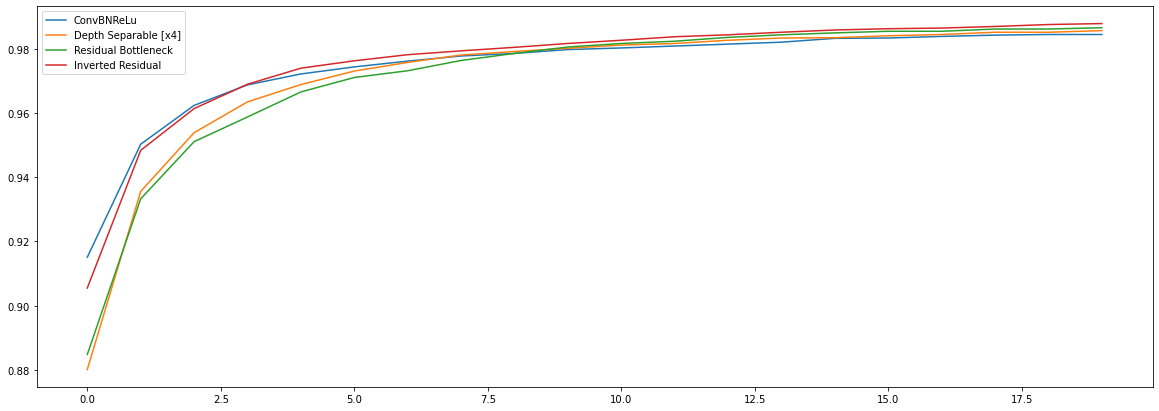

In [373]:
plt.figure(figsize=(20, 7))

plt.plot(logs_conv_bn_relu["test_acc"], label="ConvBNReLu")
plt.plot(logs_depth_separable["test_acc"], label="Depth Separable [x4]")
plt.plot(logs_residual_bottleneck["test_acc"], label="Residual Bottleneck")
plt.plot(logs_intervted_residual_block["test_acc"], label="Inverted Residual")
plt.legend()

# 3. Model
- Simple model implementation
- Parameters: width multiplier and round n_filters to a multiple

In [3]:
class ConvBNReLU6(nn.Sequential):
    """
    Generic Conv-Bn-ReLU6 Layer.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, depthwise=False, relu=True):
        groups = 1
        if depthwise:
            assert out_channels == in_channels
            groups = in_channels
        padding = (kernel_size - 1) // 2
        
        layers = [
            ("conv", nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, groups=groups, bias=False)),
            ("bn", nn.BatchNorm2d(out_channels))
        ]
        if relu:
            layers.append(("relu", nn.ReLU6(inplace=True)))
        
        super(ConvBNReLU6, self).__init__(OrderedDict(layers))
        

class InvertedResidualBlock(nn.Module):
    """
    MobileNetV2 Block: Middle conv layer should expand channel dimesnionality, is efficient due to being depthwise separable.
    Last pw layer is the bottleneck and has no nonlinearity.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, stride=1):
        super().__init__()
        self.use_skip = stride == 1 and in_channels == out_channels
        
        # Pytorch/Keras implementations removes the first pw in the first inverted block - this is not mentioned in the paper.
        # This happens at t=1 since the nr of hidden channels is the same as the input channel nr, so no 1x1 adjustment necessary
        # I will omit this for simplicity
        
        self.residual = nn.Sequential(
            ConvBNReLU6(in_channels, hidden_channels, kernel_size=1, depthwise=False),
            ConvBNReLU6(hidden_channels, hidden_channels, kernel_size=3, depthwise=True, stride=stride),
            ConvBNReLU6(hidden_channels, out_channels, kernel_size=1, depthwise=False, relu=False),
        )
    
    def forward(self, X):
        out = self.residual(X)
        if self.use_skip:
            out = out + X
        return out
        

def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class MobileNetV2(nn.Sequential):
    """
    For CIFAR
    """
    
    def __init__(self, n_classes=100, width_mult=1., round_nearest=8):
        """
        :param width_mult: multiplier for nr of filters in conv layers
        :param round_nearest: ensure width (nr filters) is a multiple of this
        """
        
        setting = [
            #t, c,  n, s
            [1, 16,  1, 1],
            [6, 24,  2, 1],
            [6, 32,  3, 1],
            [6, 64,  4, 2],
            [6, 96,  3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
        
        layers = []
        
        # First Layers
        in_channels = _make_divisible(32 * width_mult, round_nearest)
        layers.extend([
            ConvBNReLU6(in_channels=3, out_channels=in_channels)
        ])
        
        # Inverted Residual Bottleneck Layers
        for t, c, n, s in setting:
            out_channels = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                hidden_channels = int(round(in_channels * t))
                layers.extend([
                    InvertedResidualBlock(in_channels, hidden_channels, out_channels, stride=stride)
                ])
                in_channels = out_channels

        # Last Layers
        # As per paper, do not apply width multiplier less than 1 for last conv layer.
        last_channels = _make_divisible(1280 * max(1.0, width_mult), round_nearest)
        layers.extend([
            ConvBNReLU6(in_channels, last_channels, kernel_size=1),
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.Linear(last_channels, n_classes),
        ])
        
        super().__init__(*layers)
        self.init_weights()
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

# 3.1 Benchmarking MobileNetV2
- Comparing to VGG16, ResNet50
- Using MobileNetV2s at different widths to get similar param sizes as the baselines
- Note on VGG: Replaced the two fc layers for one - so a lot less params
- Results on CIFAR100: ResNet50 and VGG16 get better results than MN(width=1)
- Resnets converge slower, but get higher results
- Higher width multiplier leads to higher perf.

In [35]:
from my_utils import set_torch_seed


def get_loaders(batch_size=128):
    normalise = transforms.Normalize([0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761])
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalise,
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalise,
    ])
    ds_path = "/data/datasets/CIFAR100"
    train_ds = CIFAR100(root=ds_path, train=True, transform=transform_train)
    test_ds = CIFAR100(root=ds_path, train=False, transform=transform_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)
    return train_loader, test_loader


def train(model, n_epochs=200, batch_size=128, seed=0, device="cuda:0"):
    start_time = datetime.now()
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser, T_max=n_epochs)
    amp_scaler = torch.cuda.amp.GradScaler()
    logs = defaultdict(list)
    train_loader, test_loader = get_loaders(batch_size=batch_size)
    
    set_torch_seed(seed)
    for epoch in range(n_epochs):
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device) 
            with torch.cuda.amp.autocast():
                out = model(batch_X)
                loss = criterion(out, batch_y)

            optimiser.zero_grad()     
            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimiser)
            amp_scaler.update()
            
        scheduler.step()
        logs["test_acc"].append(get_acc(model, test_loader))
    logs["duration"] = datetime.now() - start_time
    return logs    

In [6]:
from torchvision.models import vgg16_bn, resnet50

def get_vgg16(n_classes=100):
    model = vgg16_bn(pretrained=False)
    model.features = model.features[:-1]  # dropping the last maxpool
    model.avgpool = nn.AvgPool2d(kernel_size=2)
    model.classifier = nn.Sequential(nn.Linear(512, n_classes))
    return model

def get_resnet50(n_classes=100):
    model = resnet50(pretrained=False)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False)
    model.maxpool = nn.Sequential()
    model.fc = nn.Sequential(nn.Linear(2048, n_classes))
    return model

In [36]:
models = {
    "MN0p5": MobileNetV2(width_mult=0.5),
    "MN1": MobileNetV2(width_mult=1),
    "VGG16": get_vgg16(),
    "MN2p6": MobileNetV2(width_mult=2.6),
    "ResNet50": get_resnet50(),
    "MN3p3": MobileNetV2(width_mult=3.3),
}

In [ ]:
from thop import profile

model_stats = {
    model_name: {
        k: v for k, v in zip(
            ["MACs", "Params"], 
            profile(model.eval(), inputs=(torch.randn(1, 3, 32, 32),))
        )
    }
    for model_name, model in models.items()
}

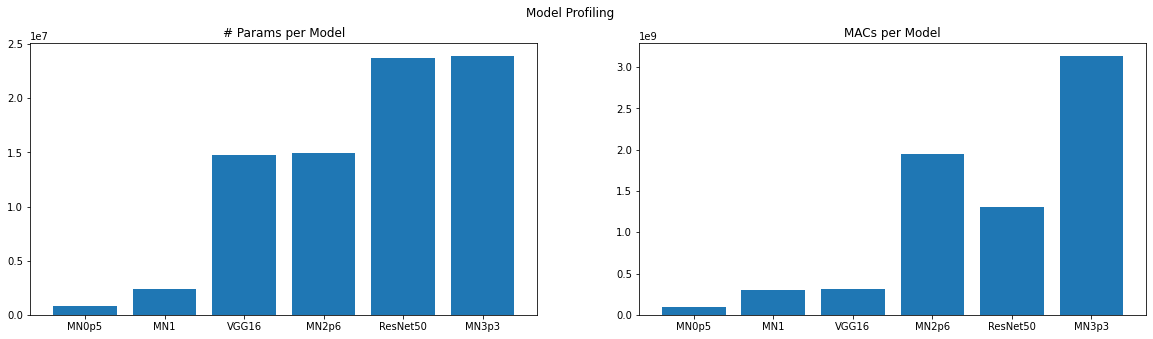

In [19]:
fig, axarr = plt.subplots(ncols=2, figsize=(20, 5))
plt.suptitle("Model Profiling")

axarr[0].set_title("# Params per Model")
axarr[0].bar(model_stats.keys(), [s["Params"] for s in model_stats.values()])


axarr[1].set_title("MACs per Model")
axarr[1].bar(model_stats.keys(), [s["MACs"] for s in model_stats.values()])

plt.show()

In [ ]:
jobs = [
    {"model": model, "n_epochs": 200, "device": device} 
    for model, device in zip(models.values(), [f"cuda:{i}" for i in range(len(models))])]

res = joblib.Parallel(n_jobs=-1)(joblib.delayed(train)(**job) for job in jobs)

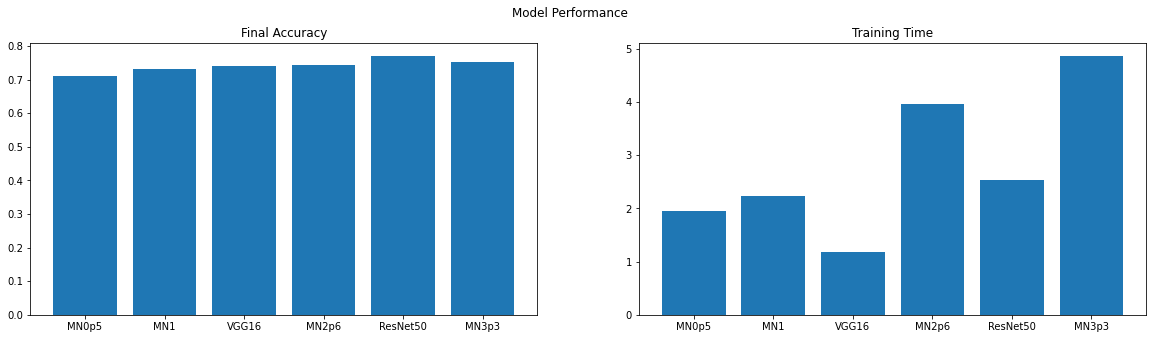

In [41]:
fig, axarr = plt.subplots(ncols=2, figsize=(20, 5))
plt.suptitle("Model Performance")

axarr[0].set_title("Final Accuracy")
axarr[0].bar(models.keys(), [log["test_acc"][-1] for log in res])


axarr[1].set_title("Training Time")
axarr[1].bar(models.keys(), [log["duration"].seconds / 60**2 for log in res])

plt.show()

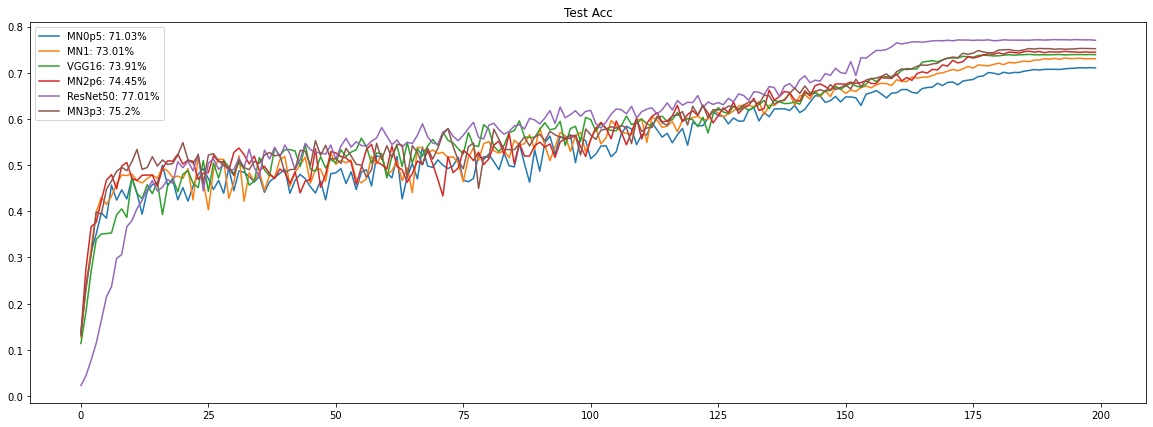

In [44]:
plt.figure(figsize=(20, 7))
plt.title("Test Acc")

for model_name, logs in zip(models.keys(), res):
    plt.plot(logs["test_acc"], label=f"{model_name}: {round(logs['test_acc'][-1] * 100, 2)}%")
plt.legend()
plt.show()